In [6]:
import pandas as pd
df = pd.read_csv('spange_melt.csv')

dictionary = {
}
solvent_types = df['solvent'].to_list()
SMILES = df['SMILES'].to_list()

for i in range(len(SMILES)):
    dictionary[SMILES[i]] = solvent_types[i]

print(dictionary)

{'C1CCCCC1': 'alkane', 'CC(=O)N(C)C': 'amide', 'CC(=O)O': 'carboxylic_acid', 'CCC(=O)OC': 'ester', 'CCOC(C)=O': 'ester', 'COC(=O)OC': 'ester', 'C1CCOC1': 'ether', 'CC1CCCO1': 'ether', 'CCOCC': 'ether', 'COC(C)(C)C': 'ether', 'CCC(C)=O': 'ketone', 'O=C1CC[C@H]2CO[C@@H]1O2': 'ketone', 'CC(C)(C)O': 'monohydric_alcohol', 'CC(C)O': 'monohydric_alcohol', 'CCCCCCCCCCO': 'monohydric_alcohol', 'CCO': 'monohydric_alcohol', 'CCOC(=O)C(C)O': 'monohydric_alcohol', 'CO': 'monohydric_alcohol', 'OC(C(F)(F)F)C(F)(F)F': 'monohydric_alcohol', 'OCC(F)(F)F': 'monohydric_alcohol', 'CC#N': 'nitrile', 'O': 'polyhydric_alcohol', 'OCCO': 'polyhydric_alcohol'}


MovieWriter ffmpeg unavailable; using Pillow instead.


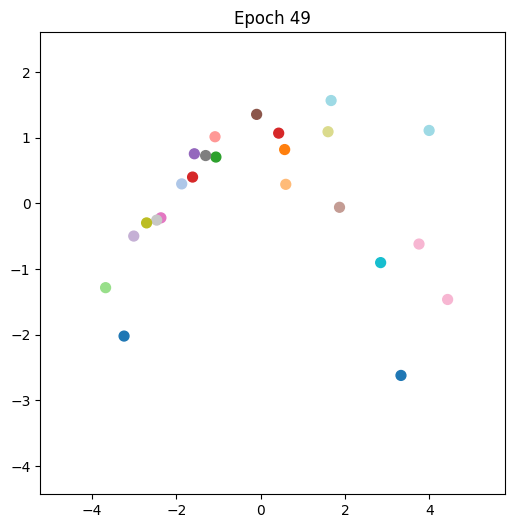

In [5]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def process_embeddings(input_dir, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    
    Args:
        input_dir (str): The path to the directory containing the JSON files.
        save_path (str, optional): Path to save the animation (e.g. "animation.mp4" or "animation.gif").
    """
    # Step 1: Load all embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(glob.glob(f"{input_dir}/fingerprints_epoch_*.json"),
                   key=lambda f: int(f.split("_")[-1].split(".")[0]))

    epoch_data = {}
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            plot_df.append({"epoch": epoch, "solvent": sid, "PC1": pc1, "PC2": pc2})

    plot_df = pd.DataFrame(plot_df)

    # Step 4: Assign a fixed color per solvent
    cmap = plt.get_cmap("tab20", len(solvent_ids))
    color_map = {sid: cmap(i) for i, sid in enumerate(solvent_ids)}

    # Step 5: Set up animation
    fig, ax = plt.subplots(figsize=(6, 6))
    scat = ax.scatter([], [], s=50)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    def init():
        scat.set_offsets(np.empty((0, 2)))  # empty array with 2 columns
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        colors = [color_map[sid] for sid in df_e["solvent"]]
        scat.set_offsets(coords)
        scat.set_color(colors)
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs), init_func=init, blit=True, repeat=True, interval=500)

    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()

# Example usage:
process_embeddings("solvent_fps", save_path="pca_animation.gif")


26
['C(C(F)(F)F)(C(F)(F)F)O', 'C1CCCCC1', 'C1CCOC1', 'CC#N', 'CC#N.CC(=O)O', 'CC(C)(C)O', 'CC(C)(C)OC', 'CC(O)C', 'CCC(=O)C', 'CCCCCCCCCCO', 'CCOC(=O)C(C)O', 'CCOCC', 'CN(C)C(C)=O', 'CO', 'COC(=O)OC', 'O.CC#N', 'O.OCC(F)(F)F', 'O1C(C)CCC1', 'O=C(OC)CC', 'O=C(OCC)C', 'OCC', 'OCC(F)(F)F', 'OCCO', '[C@H]12CCC([C@H](OC1)O2)=O'] 24


TypeError: Animation.save() got an unexpected keyword argument 'bbox_inches'

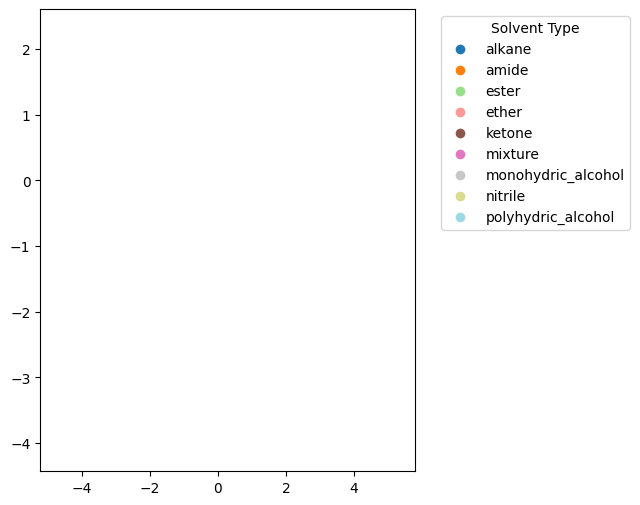

In [ ]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by solvent type (from smiles_to_type mapping) and includes a legend.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type.
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mapping
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/fingerprints_epoch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Assign a fixed color per solvent type
    solvent_types = sorted(plot_df["type"].unique())
    cmap = plt.get_cmap("tab20", len(solvent_types))
    color_map = {stype: cmap(i) for i, stype in enumerate(solvent_types)}

     # Step 5: Set up animation
    fig, ax = plt.subplots(figsize=(9, 6))  # wider figure so legend fits
    scat = ax.scatter([], [], s=50)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add legend for solvent types
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[stype], markersize=8, label=stype)
        for stype in solvent_types
    ]
    ax.legend(
        handles=legend_elements,
        title="Solvent Type",
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    def init():
        scat.set_offsets(np.empty((0, 2)))
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        colors = [color_map[stype] for stype in df_e["type"]]
        scat.set_offsets(coords)
        scat.set_color(colors)
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                        init_func=init, blit=True, repeat=True, interval=500)

    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()



# Example usage:
smiles_to_type = {
    'C1CCCCC1': 'alkane', 'CC(=O)N(C)C': 'amide', 'CC(=O)O': 'carboxylic_acid',
    'CCC(=O)OC': 'ester', 'CCOC(C)=O': 'ester', 'COC(=O)OC': 'ester',
    'C1CCOC1': 'ether', 'CC1CCCO1': 'ether', 'CCOCC': 'ether', 'COC(C)(C)C': 'ether',
    'CCC(C)=O': 'ketone', 'O=C1CC[C@H]2CO[C@@H]1O2': 'ketone',
    'CC(C)(C)O': 'monohydric_alcohol', 'CC(C)O': 'monohydric_alcohol', 'CCCCCCCCCCO': 'monohydric_alcohol',
    'CCO': 'monohydric_alcohol', 'CCOC(=O)C(C)O': 'monohydric_alcohol', 'CO': 'monohydric_alcohol',
    'OC(C(F)(F)F)C(F)(F)F': 'monohydric_alcohol', 'OCC(F)(F)F': 'monohydric_alcohol',
    'CC#N': 'nitrile', 'O': 'polyhydric_alcohol', 'OCCO': 'polyhydric_alcohol', 'CC#N.CC(=O)O': 'mixture',
    'O.CC#N': 'mixture',
    'O.OCC(F)(F)F': 'mixture'
}
print(len(list(smiles_to_type.keys())))
process_embeddings("solvent_fps", smiles_to_type, save_path="pca_by_type_with_legend.gif")
